In [1]:


from utility import *
from sampling import *
from pool import *

def runMe(sequence_length,num_rounds=3,scalar=10000,affinity_max=1e6):
    """
    Simulate a basic binding experiment.  
    """
    
    pipet = PipetteSampler()
    screen = BindingSampler()
    amplify = PhageAmplificationSampler()

    pool = Pool(sequence_length=sequence_length,alphabet=AMINO_ACIDS)
    pool.createUniformPool(100*scalar,affinity_max)

    print(0,pool.current_counts.size,sum(pool.current_counts))
    for i in range(num_rounds):
        pool.addNewStep(*pipet.runExperiment(pool,100*scalar))
        pool.addNewStep(*screen.runExperiment(pool,1*scalar))
        pool.addNewStep(*amplify.runExperiment(pool,100*scalar),checkpoint=True)

        print(i+1,pool.current_counts.size,sum(pool.current_counts))
    
    return pool




In [2]:
pool = runMe(9,num_rounds=3,scalar=10000,affinity_max=1e6)


0 999999 1000000
1 10000 1000000
2 5647 1000000
3 3927 1000000


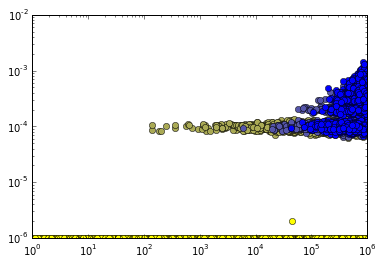

In [3]:

import matplotlib.pyplot as plt
%matplotlib inline

pool.round_affinities(0)

m = max(pool.checkpoints)
for i in pool.checkpoints:
    plt.plot(pool.round_affinities(i),pool.round_counts(i)/np.sum(pool.round_counts(i)),"o",color=[1-i/m,1-i/m,i/m])

plt.xscale('log')
plt.yscale('log')
plt.show()
    